**Hurricane Satellite Windspeed Predictions based on effnet_b0**

Chnaged effnet backbone to grayscale only
Define hyperparameter:

In [1]:
Batchsize=32
num_epochs=100
LearningRate=0.1

import required packages

In [2]:
from datetime import datetime
from efficientnet_pytorch import EfficientNet
from torch import nn
import pandas as pd
import pandas_path
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image as pil_image
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from PIL import Image as pil_image
import random
from torch.nn import functional as F
import cv2
import sys
from Datalaoder_3chanv2 import DatasetWIND
import sklearn.model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2


torch.backends.cudnn.benchmark=True

load pretained model
disable weight changes for pretrained layers
change final linear layer

In [3]:
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        model=EfficientNet.from_pretrained('efficientnet-b0',in_channels=3)
        
        model._fc=nn.Identity()
        
        self.cnn = model
        self.fc1 = nn.Linear(1282, 32)
        self.fc2 = nn.Linear(32, 1)
        self.bn   = nn.BatchNorm1d(32)
        self.swish1 =MemoryEfficientSwish()
        self.swish2 =MemoryEfficientSwish()
        
        
    def forward(self, image, data, time):
        x1 = self.cnn(image)
        x2 = data
        x3 = time
        
        x = torch.cat((x1,x2,x3), dim=1)
        x = self.swish1(self.fc1(x))
        x = self.bn(x)
        x = self.swish2(self.fc2(x))
        
        return x
        

model = MyModel()

for parameter in model.parameters():
    parameter.requires_grad = False
    
    
model.fc1.weight.requires_grad = True
model.fc2.weight.requires_grad = True
model.fc1.bias.requires_grad = True
model.fc2.bias.requires_grad = True

Loaded pretrained weights for efficientnet-b0


Old Validations set had strong bais due to time componet included

In [4]:
DATA_PATH =r'G:\HU\Data'

DATA_PATH2 =r'C:\Users\Michael\Desktop\ML'

train_metadata = pd.read_csv(DATA_PATH + "/training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH +"/training_set_labels.csv")

full_metadata = train_metadata.merge(train_labels, on="image_id")

full_metadata["file_name"] = (
    DATA_PATH2 + "/train/" + full_metadata.image_id.path.with_suffix(".jpg")
)

# Add a temporary column for number of images per storm
images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")

storm_counts = train_metadata.groupby("storm_id").size()
df=pd.DataFrame(storm_counts,columns=["counts"]).reset_index()
df["class"]=1*(df.counts>100)+1*(df.counts>200)+1*(df.counts>300)+1*(df.counts>400)+1*(df.counts>500)+1*(df.counts>600)

sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1,  test_size=0.2,random_state=999)
split = sss.split(df, df["class"])

for a,b in split:
    IDs_train=df.iloc[a].storm_id
    IDs_val=df.iloc[b].storm_id

train=full_metadata[full_metadata["storm_id"].isin(IDs_train)].drop(
    ["images_per_storm",], axis=1
)
val=full_metadata[full_metadata["storm_id"].isin(IDs_val)].drop(
    ["images_per_storm",], axis=1
)  
    
print(train.head())
print(val.head())

  image_id storm_id  relative_time  ocean  wind_speed  \
0  abs_000      abs              0      2          43   
1  abs_001      abs           1800      2          44   
2  abs_002      abs           5400      2          45   
3  abs_003      abs          17999      2          52   
4  abs_004      abs          19799      2          53   

                                       file_name  
0  C:\Users\Michael\Desktop\ML/train/abs_000.jpg  
1  C:\Users\Michael\Desktop\ML/train/abs_001.jpg  
2  C:\Users\Michael\Desktop\ML/train/abs_002.jpg  
3  C:\Users\Michael\Desktop\ML/train/abs_003.jpg  
4  C:\Users\Michael\Desktop\ML/train/abs_004.jpg  
   image_id storm_id  relative_time  ocean  wind_speed  \
57  acd_000      acd              0      1          30   
58  acd_001      acd           1800      1          30   
59  acd_002      acd           3600      1          30   
60  acd_003      acd           5400      1          30   
61  acd_004      acd          12598      1          30   

  

define transforms

In [5]:
transform_train =A.Compose(
    [
        A.transforms.CenterCrop(224,224,always_apply=True),
        A.transforms.Blur(5,p=0.1),
        A.transforms.Blur(11,p=0.2),
        #A.transforms.Cutout(p=0.2),
        #A.imgaug.transforms.IAASharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.2),
        A.augmentations.transforms.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=180,p=0.5),
        A.transforms.Normalize (mean=(0.485, ), std=(0.229, ), max_pixel_value=255.0,  p=1.0,always_apply=True),
        ToTensorV2()
    ]
)

transform_val =A.Compose(
    [
        A.transforms.CenterCrop(224,224,always_apply=True),
        A.transforms.Normalize (mean=(0.485, ), std=(0.229, ), max_pixel_value=255.0, p=1.0,always_apply=True),
        ToTensorV2()
    ]
)
transform_val

Compose([
  CenterCrop(always_apply=True, p=1.0, height=224, width=224),
  Normalize(always_apply=True, p=1.0, mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [6]:
val_set=DatasetWIND(x_train=val.drop("wind_speed",axis=1),transforms=transform_val,y_train=val["wind_speed"])
valloader=torch.utils.data.DataLoader(val_set,batch_size=Batchsize,shuffle=False,num_workers=16,pin_memory=True)

train_set=DatasetWIND(x_train=train.drop("wind_speed",axis=1),transforms=transform_train,y_train=train["wind_speed"])
trainloader=torch.utils.data.DataLoader(train_set,batch_size=Batchsize,shuffle=True,num_workers=16,pin_memory=True)

Define customized loss function in order to adress data imbalance (too few high windspeed images)

(array([21425., 20219., 13166.,  5838.,  4214.,  3285.,  1590.,   419.,
           74.,    27.]),
 array([ 15.,  32.,  49.,  66.,  83., 100., 117., 134., 151., 168., 185.]),
 <BarContainer object of 10 artists>)

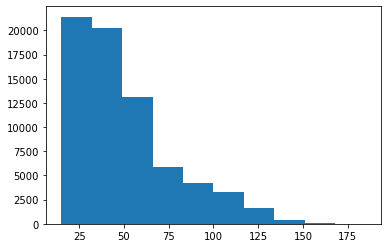

In [7]:
plt.hist(full_metadata.wind_speed)

In [8]:
class weighted_MSE(nn.Module):
    def __init__(self):
        super(weighted_MSE, self).__init__()
        
    def forward(self, pred, true):
        loss = torch.mean(((pred - true)**2)*(true/75))
        return loss

Set up training and validation loop

Epoch[1/100] Validation:: 100%|██████████| 439/439 [00:27<00:00, 16.12it/s, loss=201]


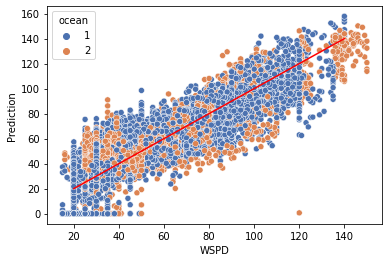

Epoch[2/100] Validation:: 100%|██████████| 439/439 [00:26<00:00, 16.82it/s, loss=190]


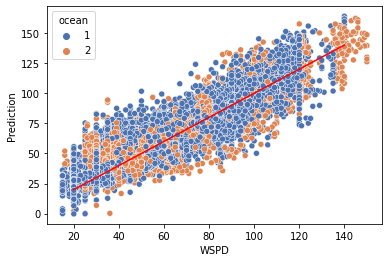

Epoch[3/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.64it/s, loss=172]


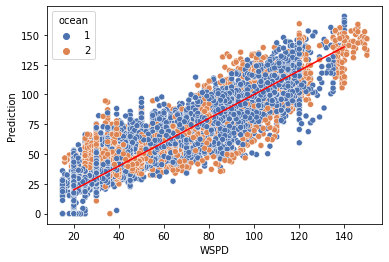

Epoch[4/100] Validation:: 100%|██████████| 439/439 [00:24<00:00, 18.22it/s, loss=166]


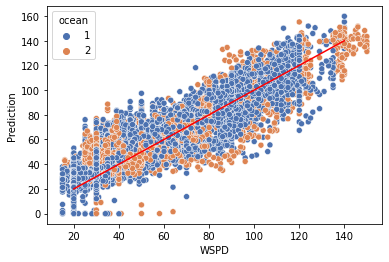

Epoch[5/100] Validation:: 100%|██████████| 439/439 [00:24<00:00, 17.85it/s, loss=185]


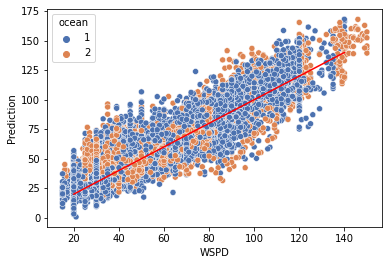

Epoch[6/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.42it/s, loss=206]


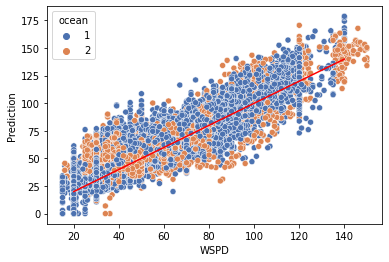

Epoch[7/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.74it/s, loss=176]


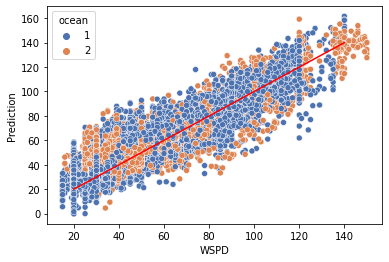

Epoch[8/100] Validation:: 100%|██████████| 439/439 [00:24<00:00, 18.16it/s, loss=183]


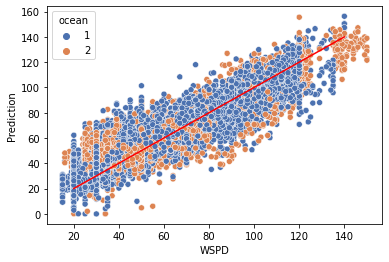

Epoch[9/100] Validation:: 100%|██████████| 439/439 [00:25<00:00, 17.03it/s, loss=160]


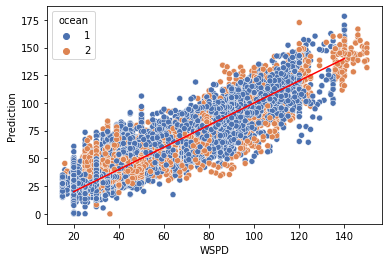

Epoch[10/100] Validation:: 100%|██████████| 439/439 [00:26<00:00, 16.81it/s, loss=151]


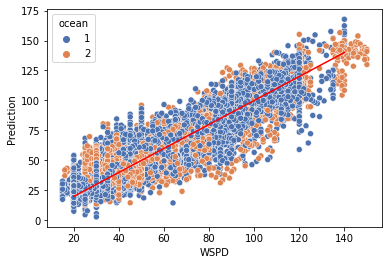

Epoch[11/100] Validation:: 100%|██████████| 439/439 [00:25<00:00, 17.38it/s, loss=103]


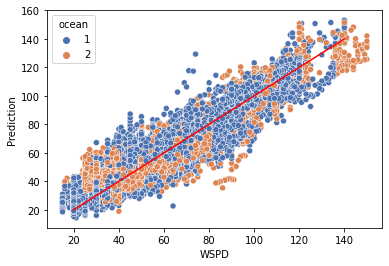

Epoch[12/100] Validation:: 100%|██████████| 439/439 [00:24<00:00, 18.02it/s, loss=101] 


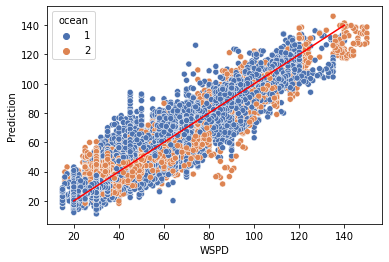

Epoch[13/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.12it/s, loss=90.7]


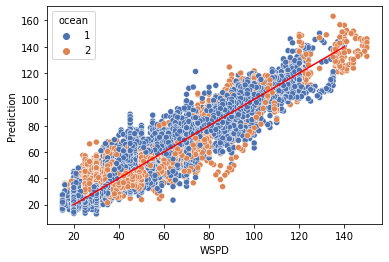

Epoch[14/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.69it/s, loss=84.5]


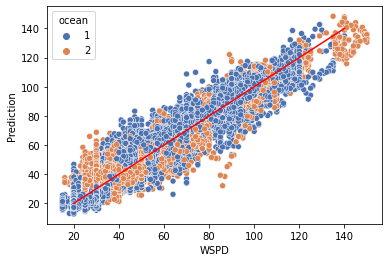

Epoch[15/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.78it/s, loss=84.9]


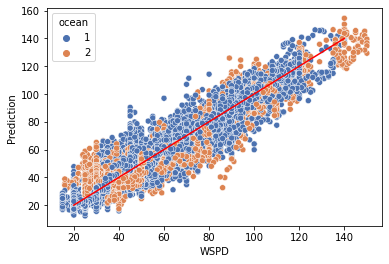

Epoch[16/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.30it/s, loss=87.1]


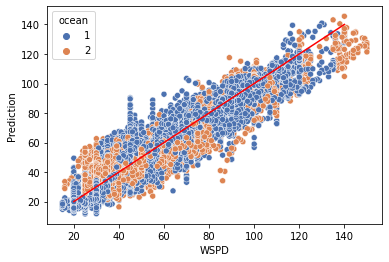

Epoch[17/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.84it/s, loss=85.4]


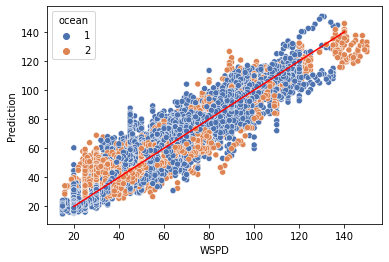

Epoch[18/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.79it/s, loss=83.4]


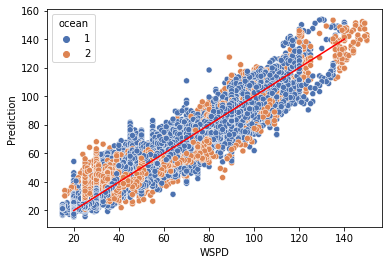

Epoch[19/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.38it/s, loss=80.2]


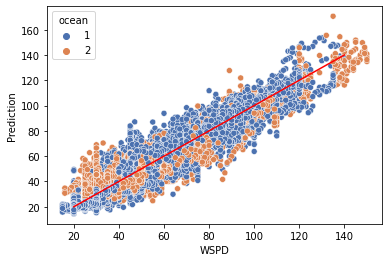

Epoch[20/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 19.04it/s, loss=87.1]


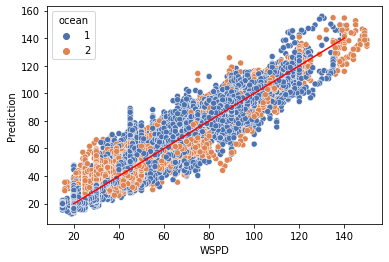

Epoch[21/100] Validation:: 100%|██████████| 439/439 [00:25<00:00, 17.11it/s, loss=81.7]


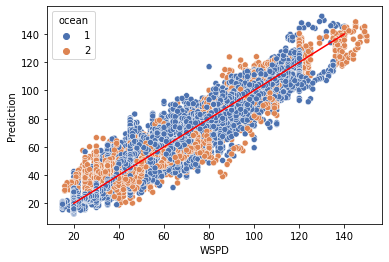

Epoch[22/100] Validation:: 100%|██████████| 439/439 [00:24<00:00, 17.76it/s, loss=83.8]


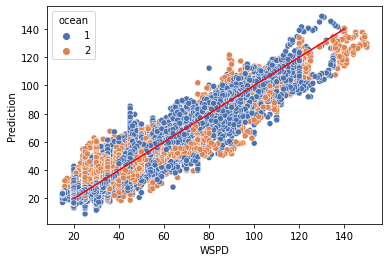

Epoch[23/100] Validation:: 100%|██████████| 439/439 [00:24<00:00, 17.86it/s, loss=82.7]


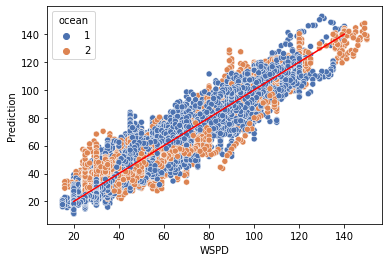

Epoch[24/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.45it/s, loss=81.7]


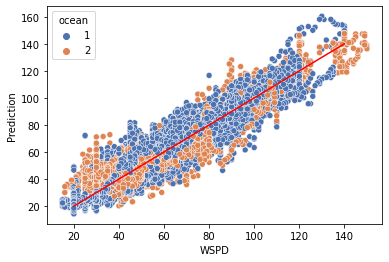

Epoch[25/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 19.09it/s, loss=80.9]


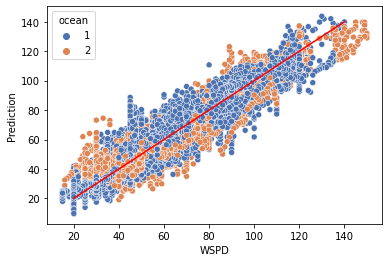

Epoch[26/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.17it/s, loss=80.2]


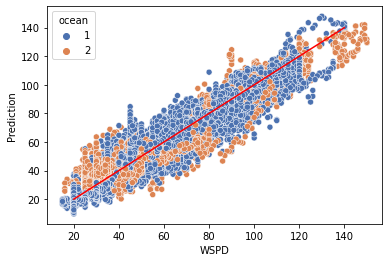

Epoch[27/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.11it/s, loss=78.3]


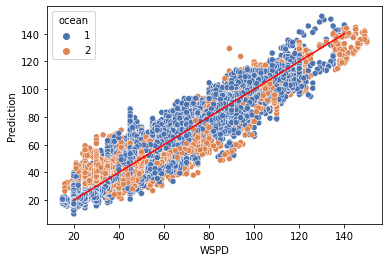

Epoch[28/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.72it/s, loss=83.1]


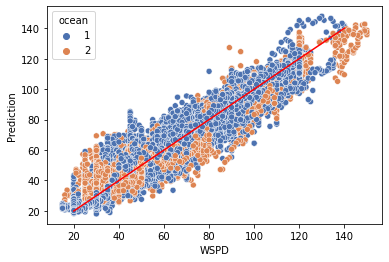

Epoch[29/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.70it/s, loss=83.1]


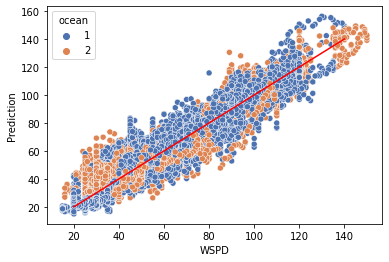

Epoch[30/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.65it/s, loss=82.9]


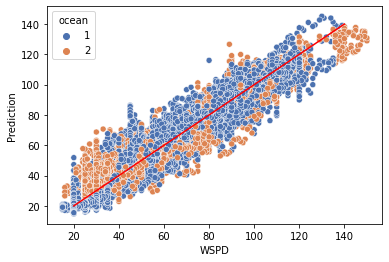

Epoch[31/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.13it/s, loss=83.6]


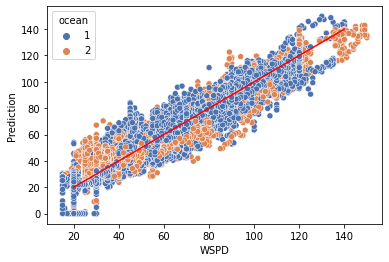

Epoch[32/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 19.04it/s, loss=78.7]


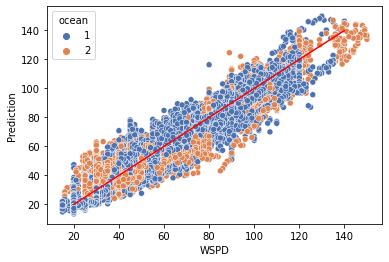

Epoch[33/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.10it/s, loss=80.2]


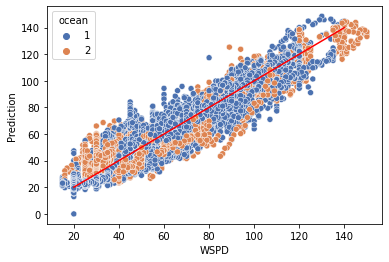

Epoch[34/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.98it/s, loss=79.3]


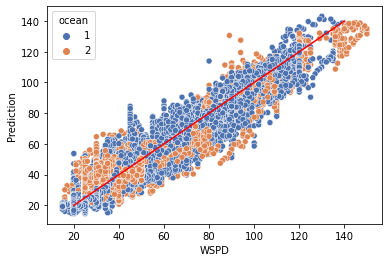

Epoch[35/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 19.03it/s, loss=80.6]


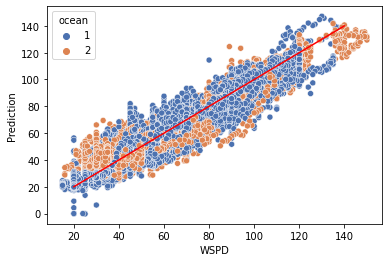

Epoch[36/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.99it/s, loss=79.8]


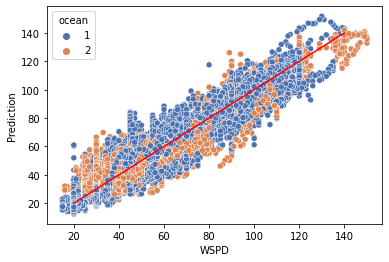

Epoch[37/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 19.08it/s, loss=83.5]


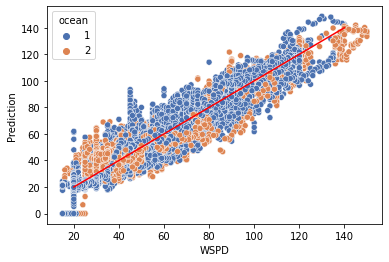

Epoch[38/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 19.04it/s, loss=79.2]


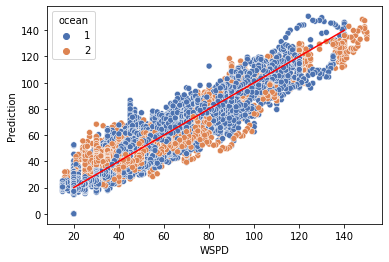

Epoch[39/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.67it/s, loss=84.4]


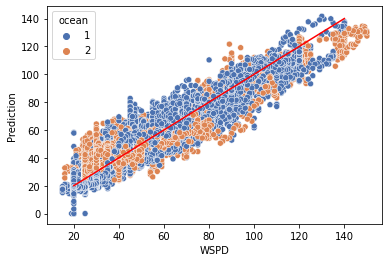

Epoch[40/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.61it/s, loss=79]  


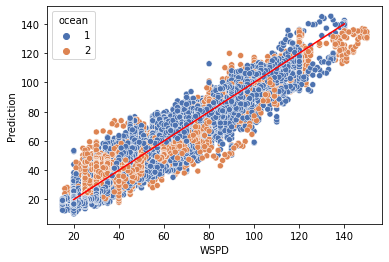

Epoch[41/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.65it/s, loss=79.7]


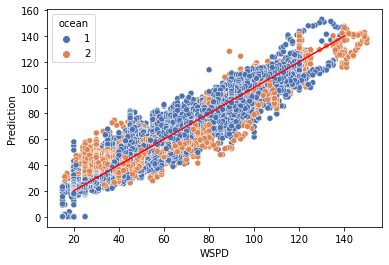

Epoch[42/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.55it/s, loss=79.1]


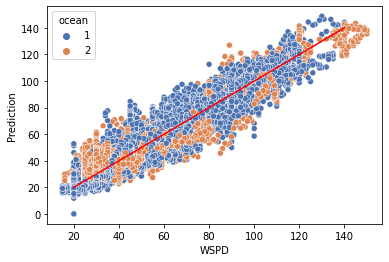

Epoch[43/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.64it/s, loss=83.8]


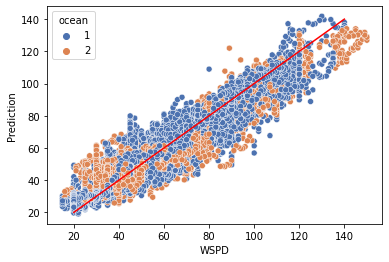

Epoch[44/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.66it/s, loss=80.9]


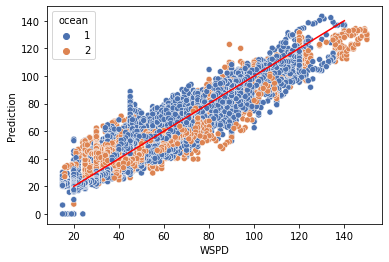

Epoch[45/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.63it/s, loss=77.6]


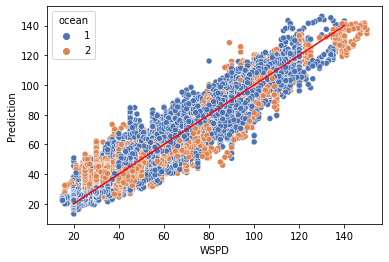

Epoch[46/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.65it/s, loss=79.2]


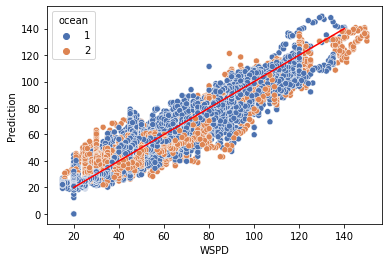

Epoch[47/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.64it/s, loss=84]  


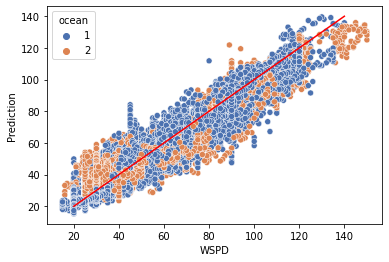

Epoch[48/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.50it/s, loss=84.1]


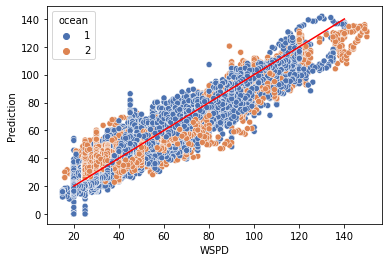

Epoch[49/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.58it/s, loss=86.8]


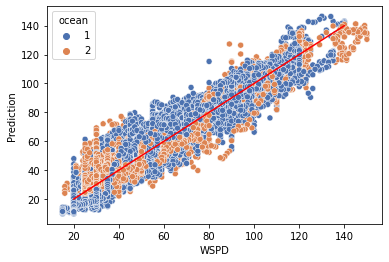

Epoch[50/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.58it/s, loss=81.1]


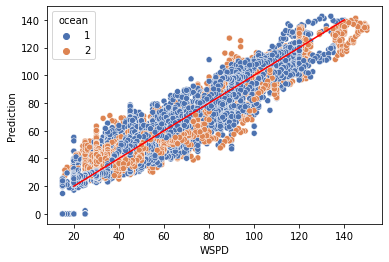

Epoch[51/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.52it/s, loss=83.6]


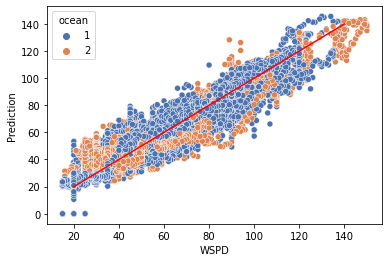

Epoch[52/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.64it/s, loss=83.2]


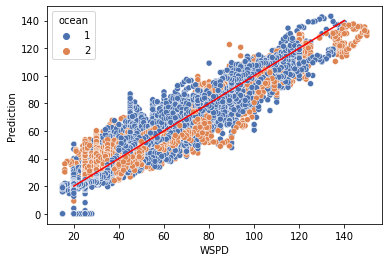

Epoch[53/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.61it/s, loss=79.3]


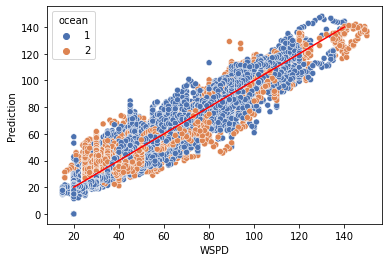

Epoch[54/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.57it/s, loss=81.2]


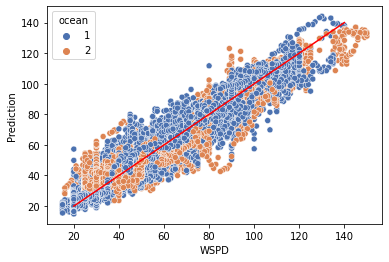

Epoch[55/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.58it/s, loss=80.3]


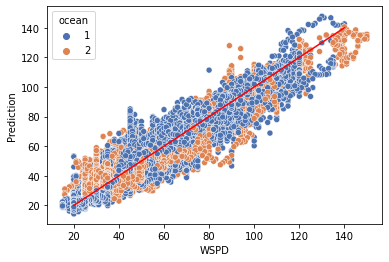

Epoch[56/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.55it/s, loss=80.9]


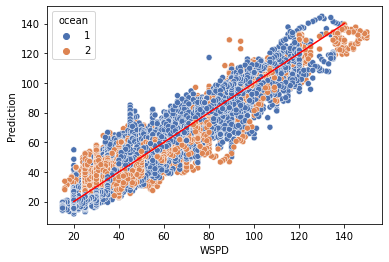

Epoch[57/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.49it/s, loss=80.6]


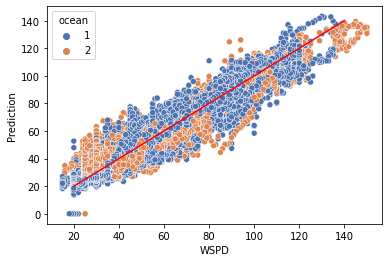

Epoch[58/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.35it/s, loss=84]  


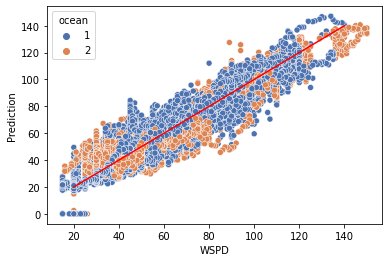

Epoch[59/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.44it/s, loss=82.2]


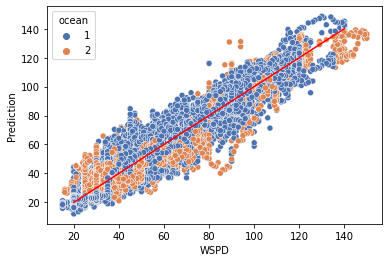

Epoch[60/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.51it/s, loss=87]  


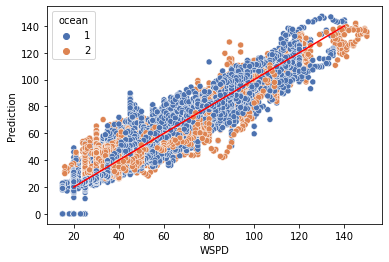

Epoch[61/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.48it/s, loss=93.5]


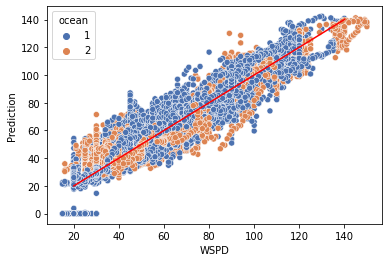

Epoch[62/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.52it/s, loss=84.2]


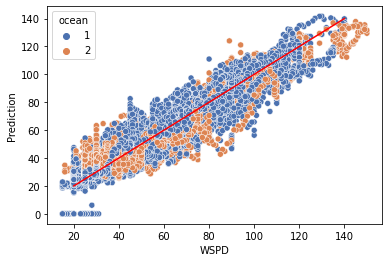

Epoch[63/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.44it/s, loss=84.1]


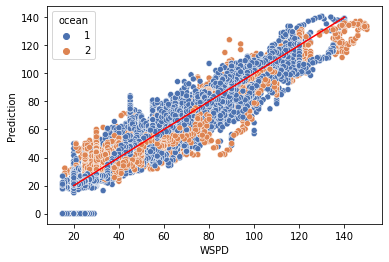

Epoch[64/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.51it/s, loss=82.9]


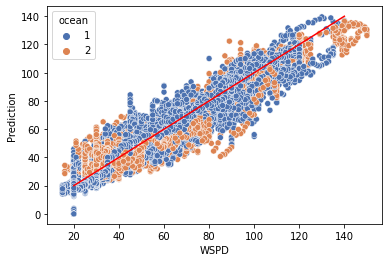

Epoch[65/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.44it/s, loss=83.6]


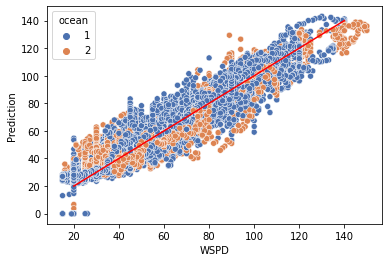

Epoch[66/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.44it/s, loss=85.4]


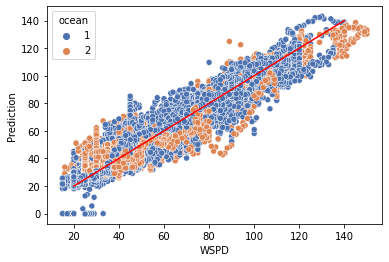

Epoch[67/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.54it/s, loss=102] 


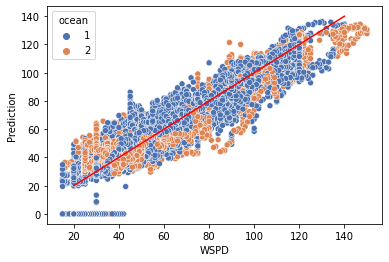

Epoch[68/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.56it/s, loss=80.3]


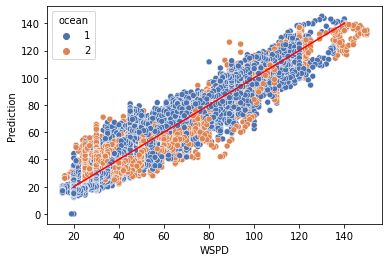

Epoch[69/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.52it/s, loss=82.2]


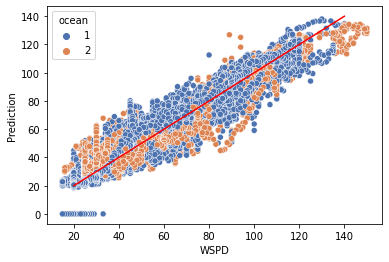

Epoch[70/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.56it/s, loss=81.1]


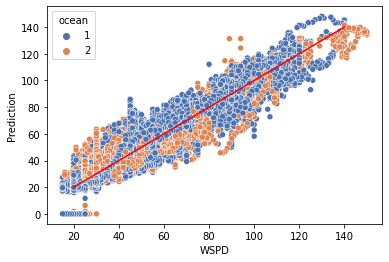

Epoch[71/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.62it/s, loss=88.1]


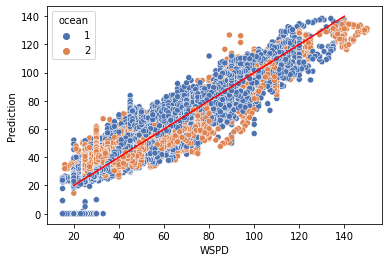

Epoch[72/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.50it/s, loss=79.3]


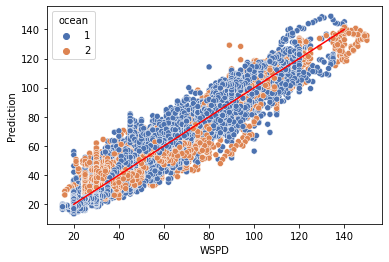

Epoch[73/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.62it/s, loss=78.7]


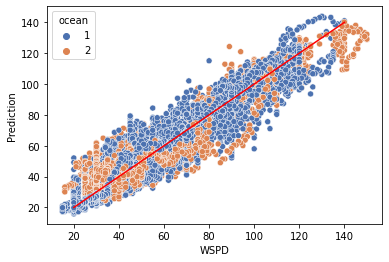

Epoch[74/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.54it/s, loss=79.8]


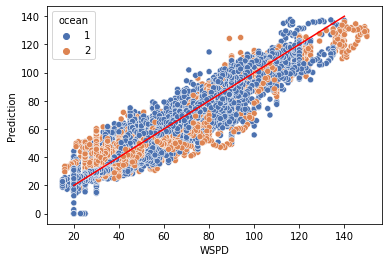

Epoch[75/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.41it/s, loss=87.4]


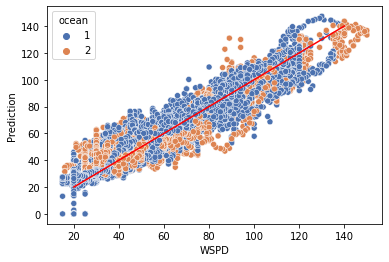

Epoch[76/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.51it/s, loss=94]  


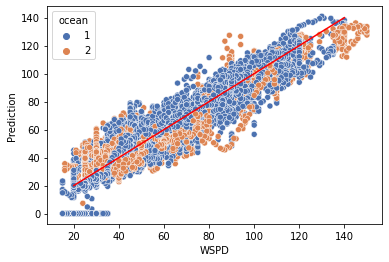

Epoch[77/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.57it/s, loss=87.6]


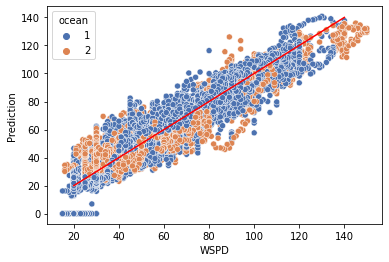

Epoch[78/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.48it/s, loss=80]  


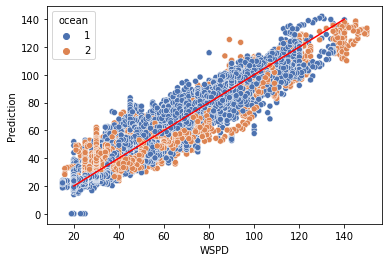

Epoch[79/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.58it/s, loss=86.7]


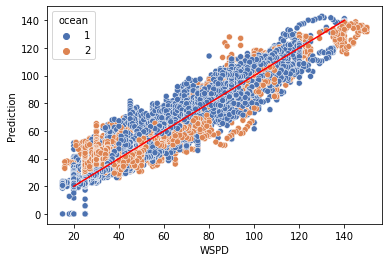

Epoch[80/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.54it/s, loss=80.2]


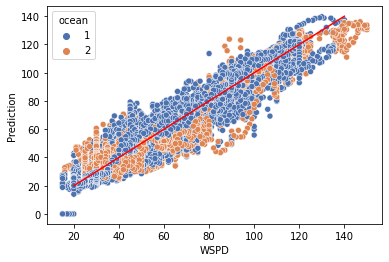

Epoch[81/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.49it/s, loss=85.1]


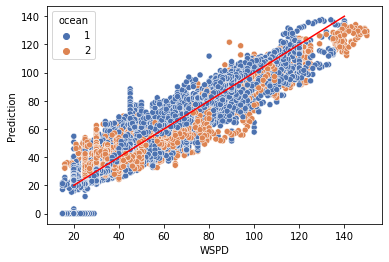

Epoch[82/100] Validation:: 100%|██████████| 439/439 [00:22<00:00, 19.54it/s, loss=84.9]


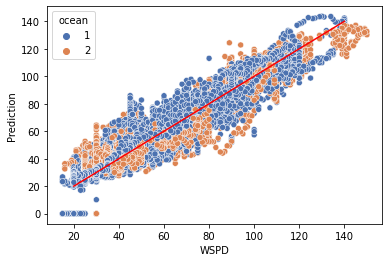

Epoch[83/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.60it/s, loss=90.2]


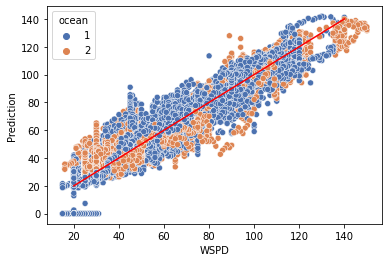

Epoch[84/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.64it/s, loss=85.3]


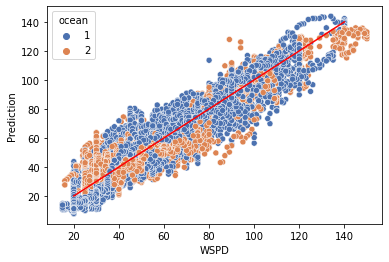

Epoch[85/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.58it/s, loss=91.6]


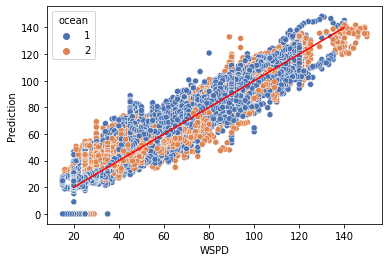

Epoch[86/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.65it/s, loss=81.3]


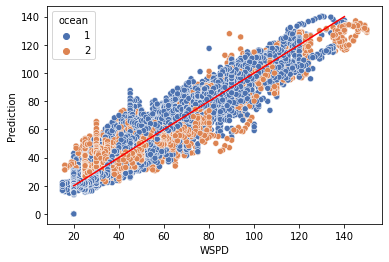

Epoch[87/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.54it/s, loss=84.4]


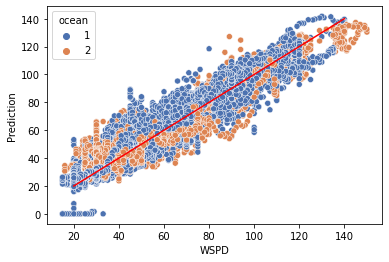

Epoch[88/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.69it/s, loss=85.1]


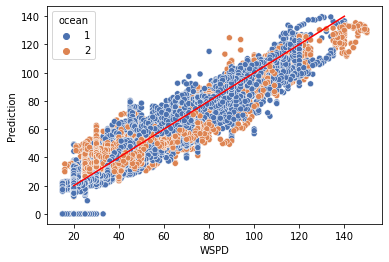

Epoch[89/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.75it/s, loss=80.5]


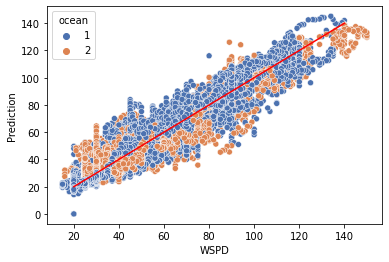

Epoch[90/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.70it/s, loss=82.7]


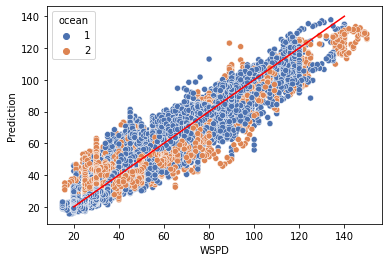

Epoch[91/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.72it/s, loss=91.2]


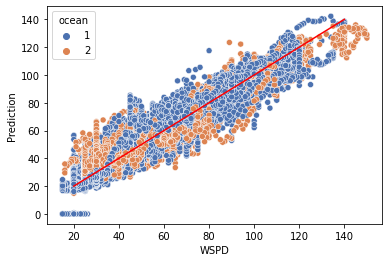

Epoch[92/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.80it/s, loss=83.3]


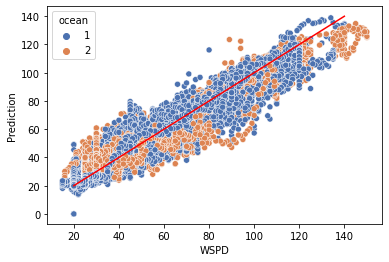

Epoch[93/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.69it/s, loss=91.6]


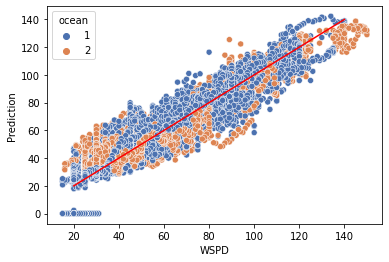

Epoch[94/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.71it/s, loss=89.2]


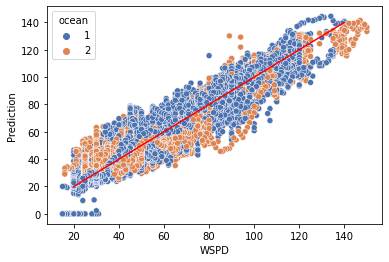

Epoch[95/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.79it/s, loss=86.9]


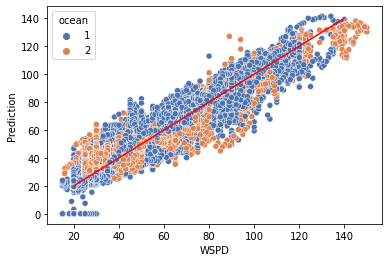

Epoch[96/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.89it/s, loss=86.6]


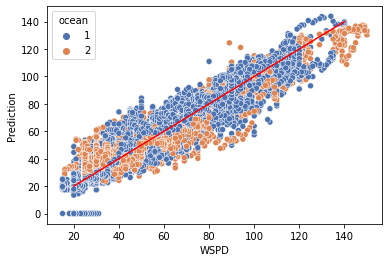

Epoch[97/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.83it/s, loss=98.5]


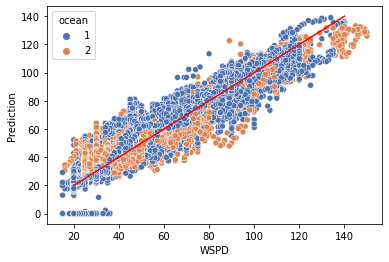

Epoch[98/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.84it/s, loss=93.4]


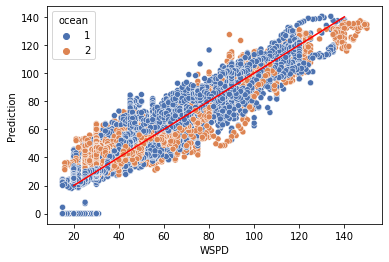

Epoch[99/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.73it/s, loss=91.1]


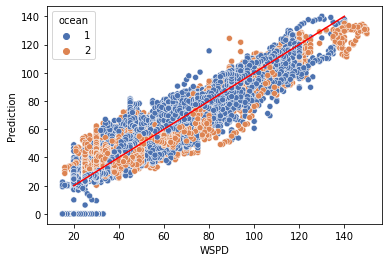

Epoch[100/100] Validation:: 100%|██████████| 439/439 [00:23<00:00, 18.75it/s, loss=85.9]


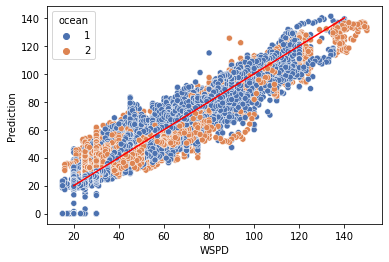

In [9]:
criterion2 = weighted_MSE()
criterion =nn.MSELoss()

#optimizer = optim.Adam(model.parameters(), lr=LearningRate)

#cp=torch.load(r'G:\HU/model/EffnetB0_2021-01-04 00-37-54_88.36531060703251.pt',map_location=('cuda:0'))
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LearningRate)



#model.load_state_dict(cp["state_dict"])
#optimizer.load_state_dict(cp['optimizer'])


model.cuda()

min_val_loss=500

for epoch in range(num_epochs):  # loop over the dataset multiple times

    if epoch==10:
        for parameter in model.parameters():
            parameter.requires_grad = True
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LearningRate*0.001)
        
    running_loss = 0.0
    running_loss2 = 0.0


    loop=tqdm(enumerate(trainloader, 0),total=len(trainloader),position=0, leave=True)

    df=pd.DataFrame(columns=["image_id","Prediction","WSPD",])
    model.train()

    for i, data in loop:


        # get the inputs; data is a list of [inputs, labels]
        inputs = data["image"].cuda()
        labels = data["label"].float().view(-1,1).cuda()
        ocean = data["ocean"].float().view(-1,1).cuda()
        time = data["time"].float().view(-1,1).cuda()
        del data

        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        # forward + backward + optimize

        outputs = model(image=inputs, data=ocean,time=time)

        loss = criterion2(outputs, labels)
        loss2 = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_loss2 += loss2.item()
        loop.set_description(f"Epoch[{epoch+1}/{num_epochs}] Training:")
        loop.set_postfix({"weighted_MSE":running_loss/(i+1),"MSE":running_loss2/(i+1)})


    
    running_loss = 0.0
    loop2=tqdm(enumerate(valloader, 0),total=len(valloader),position=0, leave=True)

    model.eval()
    with torch.no_grad():
        for i, data in loop2:
            # get the inputs; data is a list of [inputs, labels]
            inputs_val = data["image"].cuda()
            labels_val = data["label"].float().view(-1,1).cuda()
            ocean_val = data["ocean"].float().view(-1,1).cuda()
            time_val = data["time"].float().view(-1,1).cuda()

            outputs_val = model(image=inputs_val, data=ocean_val, time=time_val)

            loss_val = criterion(outputs_val, labels_val)


            d={"image_id":data["image_id"],
               "Prediction":outputs_val.cpu().detach().numpy().flatten(),
               "WSPD":labels_val.cpu().detach().numpy().flatten()}
            df2=pd.DataFrame(d)
            df=df.append(df2)

            # print statistics
            running_loss += loss_val.item()
            loop2.set_description(f"Epoch[{epoch+1}/{num_epochs}] Validation:")
            loop2.set_postfix(loss=running_loss/(i+1))


    df=df.merge(val.drop("wind_speed",axis=1),how='left',on="image_id")
    df["RMSE"]=(df["Prediction"]-df["WSPD"])**2
    X_plot = np.linspace(20, 140, 100)
    plt.plot(X_plot, X_plot, color='r')
    sns.scatterplot(data=df, x="WSPD", y="Prediction", hue="ocean",palette="deep")   
    plt.show()

    if (running_loss/len(valloader)) < min_val_loss:
        today = datetime.now()
        checkpoint = {'epoch': epoch,
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict()}

        PATH = r'G:\HU/model/EffnetB0_'+today.strftime("%Y-%m-%d %H-%M-%S")+'_'+str(running_loss/len(valloader))+'.pt'
        torch.save(checkpoint, PATH)

        min_val_loss=np.min([min_val_loss,(running_loss/len(valloader))])





In [10]:
np.mean(df[df["ocean"]==2]["RMSE"])

90.715576

In [11]:
np.mean(df[df["ocean"]==1]["RMSE"])

83.2855

In [12]:
np.mean(df["RMSE"])

85.890526

In [13]:
min_val_loss

77.55594927031792

In [14]:
df["ER"]=df["Prediction"]-df["WSPD"]

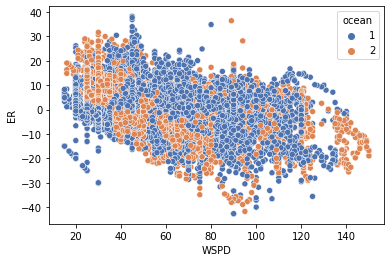

In [15]:
sns.scatterplot(data=df, x="WSPD", y="ER", hue="ocean",palette="deep")   
plt.show()

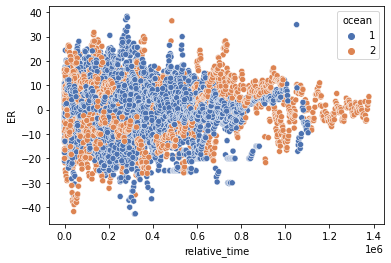

In [16]:
sns.scatterplot(data=df, x="relative_time", y="ER", hue="ocean",palette="deep")   
plt.show()